# MNIST Deep Learning Project

This script implements a fully connected neural network to classify modified MNIST datasets.
No convolutional layers are used. Four datasets are supported:

    Dataset 1: 
        - Training: first 50,000 images of MNIST training set.
        - Testing: original 10,000 MNIST test images.
    
    Dataset 2:
        - Training: first 1,000 images of MNIST training set.
        - Testing: original 10,000 MNIST test images.
    
    Dataset 3:
        - Training & Testing: full MNIST sets with preprocessing (add 765 to every pixel then divide by 4).
    
    Dataset 4:
        - Custom dataset: form new images by concatenating three MNIST images (stacked vertically)
          from three overlapping subsets:
            • Training: [0:40000], [10000:50000], [20000:60000] → 40,000 new images.
            • Testing:  [0:8000], [1000:9000], [2000:10000] → 8,000 new images.
          New label = 100 * (digit from subset 1) + 10 * (digit from subset 2) + (digit from subset 3).

The results are printed during training and three curves (loss, training accuracy, testing accuracy)
are plotted at the end.

## Implementing the Fully-Connected Neural Network

Below are the libraries that need to be imported prior to creating the **fully-connected neural network**.

In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
import numpy as np
import matplotlib.pyplot as plt
import math
import argparse

The next code block features the **fully-connected neural network**.

In [77]:
# ---------------------------
# Fully Connected Network
# ---------------------------
class FullyConnectedNet(nn.Module):
    def __init__(self, input_size, hidden_units_list, num_classes, init_method='xavier'):
        super(FullyConnectedNet, self).__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_units_list:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, num_classes))
        self.model = nn.Sequential(*layers)
        self._initialize_weights(init_method)
        
    def _initialize_weights(self, init_method):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if init_method == 'xavier':
                    nn.init.xavier_uniform_(m.weight)
                elif init_method == 'he':
                    nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
                    
    def forward(self, x):
        return self.model(x)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Next, we have our training function. 

In [78]:
# ---------------------------
# Training Function
# ---------------------------
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    train_loss_history = []
    train_acc_history = []
    test_acc_history = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # Flatten input images: For FC network all inputs must be 1D
            inputs = inputs.view(inputs.size(0), -1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        epoch_loss = running_loss / total
        epoch_train_acc = 100. * correct / total
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_train_acc)
        
        # Evaluate test set
        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = inputs.view(inputs.size(0), -1)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total_test += labels.size(0)
                correct_test += predicted.eq(labels).sum().item()
        test_acc = 100. * correct_test / total_test
        test_acc_history.append(test_acc)
        print(f"Epoch {epoch+1}/{num_epochs} -- Loss: {epoch_loss:.4f} | Train Acc: {epoch_train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
        
    return train_loss_history, train_acc_history, test_acc_history

Next, we will plot our function. 

In [79]:
# ---------------------------
# Plotting Function
# ---------------------------
def plot_curves(train_loss, train_acc, test_acc, title="Training Curves"):
    epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(14,4))
    
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_acc, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Training Accuracy (%)')
    plt.title('Training Accuracy vs Epochs')
    
    plt.subplot(1, 3, 3)
    plt.plot(epochs, test_acc, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Testing Accuracy (%)')
    plt.title('Testing Accuracy vs Epochs')
    
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

## Datasets

We will implement this over four different datasets.

### Dataset I

- **Training Set**: The first 50,000 of the original 60,000 training images.
- **Testing Set**: Same as the original testing set.

In [80]:
# ---------------------------
# Dataset 1: First 50,000 of MNIST training set
# ---------------------------
def get_dataset1(batch_size):
    transform = transforms.ToTensor()
    train_dataset_full = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    train_dataset = Subset(train_dataset_full, list(range(50000)))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

### Dataset II

- **Training Set**: The first 1,000 of the original training images.
- **Testing Set**: Same as the original testing set.

In [81]:
# ---------------------------
# Dataset 2: First 1,000 of MNIST training set
# ---------------------------
def get_dataset2(batch_size):
    transform = transforms.ToTensor()
    train_dataset_full = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    train_dataset = Subset(train_dataset_full, list(range(1000)))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

### Dataset III

- Use the full MNIST training and testing set but add 765 to all pixel values of the images and then divide by 4 (the resulting data may be thought of as brightened images).

In [82]:
# ---------------------------
# Dataset 3: Full MNIST with modified pixel values
# Operation: (pixel_value*255 + 765) / 4 then (optionally) re-normalize to [0,1]
# ---------------------------
class Add765Divide4(object):
    def __call__(self, tensor):
        # Tensor initially is scaled to [0, 1]; convert to [0, 255] then apply transformation.
        tensor = tensor * 255.0
        tensor = (tensor + 765.0) / 4.0
        # Option: scale back to [0,1] if needed.
        return tensor / 255.0

def get_dataset3(batch_size):
    transform = transforms.Compose([transforms.ToTensor(), Add765Divide4()])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

### Dataset IV

- **Training Set**: Take the first 40,000, the next 40,000 starting from the 10,001st, and the last 40,000 of the original training images, line them up in three rows, and then concatenate three images in each column to make 40,000 three-digit images. 
- **Testing Set**: Concatenate in the same way the first 8,000, the next 8,000 starting from the 1,001st, and the last 8,000 of the original testing images. The output will be ordered three-digit that may be labeled as a number between 0 and 999. 

In [83]:
# ---------------------------
# Dataset 4: Concatenated three-digit images
# ---------------------------
class ConcatMNISTDataset(Dataset):
    def __init__(self, dataset1, dataset2, dataset3, transform=None):
        """
        dataset1, dataset2, dataset3: Sub-datasets (e.g., Subset objects) of MNIST,
        each of the same length.
        The new image is constructed by vertically concatenating the three images.
        The new label is computed as: 100*label1 + 10*label2 + label3.
        """
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.dataset3 = dataset3
        self.transform = transform
        self.length = len(dataset1)  # assume all three subsets have the same length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        img1, label1 = self.dataset1[idx]
        img2, label2 = self.dataset2[idx]
        img3, label3 = self.dataset3[idx]
        # Each image is (1, 28, 28); concatenate along the height (dimension 1)
        new_img = torch.cat((img1, img2, img3), dim=1)  # Resulting shape: (1, 84, 28)
        new_label = 100 * label1 + 10 * label2 + label3  # Three-digit number (0-999)
        if self.transform:
            new_img = self.transform(new_img)
        return new_img, new_label

def get_dataset4(batch_size):
    transform = transforms.ToTensor()  # MNIST images will be converted to tensors.
    # Load full MNIST datasets.
    train_dataset_full = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset_full  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    # Training subsets:
    subset1 = Subset(train_dataset_full, list(range(0, 40000)))              # first 40,000 images
    subset2 = Subset(train_dataset_full, list(range(10000, 10000+40000)))      # next 40,000 from 10,001st
    subset3 = Subset(train_dataset_full, list(range(20000, 60000)))             # last 40,000 images

    train_concat_dataset = ConcatMNISTDataset(subset1, subset2, subset3)
    
    # Testing subsets:
    test_subset1 = Subset(test_dataset_full, list(range(0, 8000)))             # first 8,000 images
    test_subset2 = Subset(test_dataset_full, list(range(1000, 1000+8000)))       # next 8,000 from 1,001st
    test_subset3 = Subset(test_dataset_full, list(range(2000, 10000)))           # last 8,000 images

    test_concat_dataset = ConcatMNISTDataset(test_subset1, test_subset2, test_subset3)
    
    train_loader = DataLoader(train_concat_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_concat_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

Next, we will go through our main routine. 

## Project I Results

See the below code:

Using Dataset 1: 50,000 training images (original MNIST)


100%|██████████| 9.91M/9.91M [00:00<00:00, 11.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.15MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 7.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


Total number of parameters: 235146
Starting training...

Epoch 1/20 -- Loss: 0.3020 | Train Acc: 91.25% | Test Acc: 95.66%
Epoch 2/20 -- Loss: 0.1162 | Train Acc: 96.53% | Test Acc: 96.88%
Epoch 3/20 -- Loss: 0.0746 | Train Acc: 97.75% | Test Acc: 97.48%
Epoch 4/20 -- Loss: 0.0524 | Train Acc: 98.41% | Test Acc: 97.70%
Epoch 5/20 -- Loss: 0.0376 | Train Acc: 98.84% | Test Acc: 97.37%
Epoch 6/20 -- Loss: 0.0294 | Train Acc: 99.05% | Test Acc: 97.59%
Epoch 7/20 -- Loss: 0.0219 | Train Acc: 99.31% | Test Acc: 97.81%
Epoch 8/20 -- Loss: 0.0166 | Train Acc: 99.52% | Test Acc: 98.07%
Epoch 9/20 -- Loss: 0.0142 | Train Acc: 99.54% | Test Acc: 98.03%
Epoch 10/20 -- Loss: 0.0144 | Train Acc: 99.57% | Test Acc: 97.43%
Epoch 11/20 -- Loss: 0.0117 | Train Acc: 99.62% | Test Acc: 97.96%
Epoch 12/20 -- Loss: 0.0120 | Train Acc: 99.59% | Test Acc: 97.72%
Epoch 13/20 -- Loss: 0.0094 | Train Acc: 99.71% | Test Acc: 98.08%
Epoch 14/20 -- Loss: 0.0105 | Train Acc: 99.65% | Test Acc: 97.89%
Epoch 15/20 --

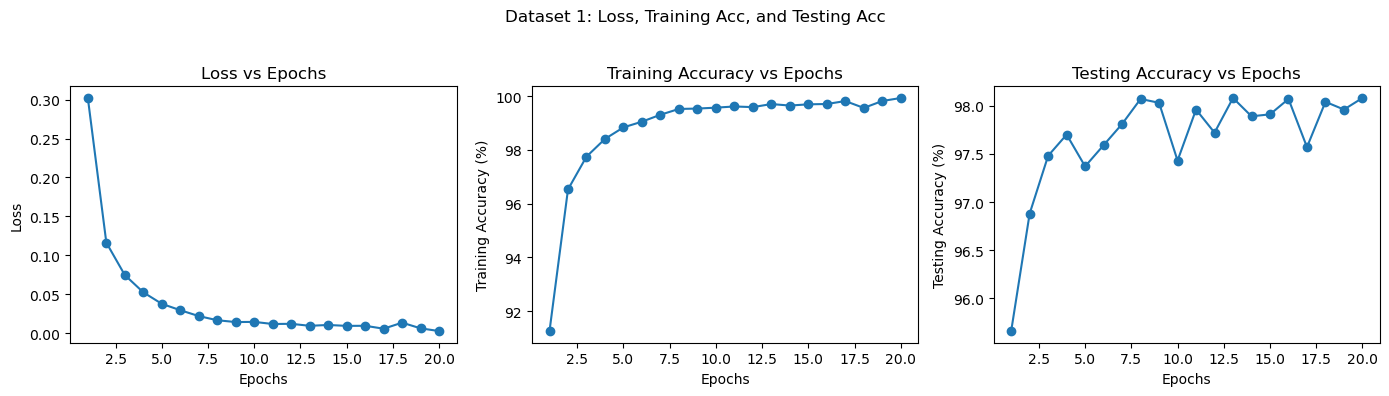

In [ ]:
# ---------------------------
# Main Routine for Dataset 1
# ---------------------------
if __name__ == '__main__':
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Configuration: select which dataset to train (1,2,3, or 4)
    dataset_choice = 1  # CHANGE THIS value to 1, 2, 3, or 4
    
    # Hyperparameters (adjust as desired)
    batch_size = 128
    num_epochs = 20
    learning_rate = 0.001
    optimizer_choice = 'adam'  # or 'sgd'
    init_method = 'xavier'     # or 'he'
    hidden_units_list = [256, 128]  # example hidden layer sizes
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Select dataset and define input/output dimensions based on dataset
    if dataset_choice == 1:
        print("Using Dataset 1: 50,000 training images (original MNIST)")
        train_loader, test_loader = get_dataset1(batch_size)
        input_size = 28 * 28  # flattened image size
        num_classes = 10
    elif dataset_choice == 2:
        print("Using Dataset 2: 1,000 training images (original MNIST)")
        train_loader, test_loader = get_dataset2(batch_size)
        input_size = 28 * 28
        num_classes = 10
    elif dataset_choice == 3:
        print("Using Dataset 3: Full MNIST with modified brightness")
        train_loader, test_loader = get_dataset3(batch_size)
        input_size = 28 * 28
        num_classes = 10
    elif dataset_choice == 4:
        print("Using Dataset 4: Concatenated three-digit images")
        train_loader, test_loader = get_dataset4(batch_size)
        # Each new image is (1, 84, 28) after vertical stacking.
        input_size = 84 * 28
        num_classes = 1000  # labels range from 0 to 999
        # For more complex task consider adjusting network architecture.
        hidden_units_list = [512, 256, 128]  # example for higher capacity
    else:
        raise ValueError("dataset_choice must be 1, 2, 3, or 4")
    
    # Create model
    model = FullyConnectedNet(input_size, hidden_units_list, num_classes, init_method=init_method)
    total_params = count_parameters(model)
    print(f"Total number of parameters: {total_params}")

    # Define loss criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    if optimizer_choice.lower() == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    # Train the network
    print("Starting training...\n")
    train_loss, train_acc, test_acc = train_model(model, train_loader, test_loader,
                                                  criterion, optimizer, num_epochs, device)
    
    # Compute final accuracies and score ratio:
    final_train_acc = train_acc[-1]
    final_test_acc  = test_acc[-1]
    score_ratio = final_test_acc / (total_params ** (1/10))
    print(f"\nFinal Training Accuracy: {final_train_acc:.2f}%")
    print(f"Final Testing Accuracy: {final_test_acc:.2f}%")
    print(f"Score Ratio: {score_ratio:.4f}")
    
    # Plot training convergence curves
    plot_title = f"Dataset {dataset_choice}: Loss, Training Acc, and Testing Acc"
    plot_curves(train_loss, train_acc, test_acc, title=plot_title)

Next, let us see this routine applied to the second dataset. 

Using Dataset 2: 1,000 training images (original MNIST)
Total number of parameters: 235146
Starting training...

Epoch 1/20 -- Loss: 1.9495 | Train Acc: 46.40% | Test Acc: 71.52%
Epoch 2/20 -- Loss: 1.0196 | Train Acc: 81.00% | Test Acc: 78.35%
Epoch 3/20 -- Loss: 0.5462 | Train Acc: 87.10% | Test Acc: 82.56%
Epoch 4/20 -- Loss: 0.3758 | Train Acc: 89.40% | Test Acc: 85.67%
Epoch 5/20 -- Loss: 0.2865 | Train Acc: 92.30% | Test Acc: 86.28%
Epoch 6/20 -- Loss: 0.2210 | Train Acc: 94.50% | Test Acc: 87.05%
Epoch 7/20 -- Loss: 0.1776 | Train Acc: 95.60% | Test Acc: 87.52%
Epoch 8/20 -- Loss: 0.1403 | Train Acc: 96.90% | Test Acc: 86.81%
Epoch 9/20 -- Loss: 0.1170 | Train Acc: 97.60% | Test Acc: 88.17%
Epoch 10/20 -- Loss: 0.0989 | Train Acc: 98.00% | Test Acc: 87.20%
Epoch 11/20 -- Loss: 0.0749 | Train Acc: 98.70% | Test Acc: 88.11%
Epoch 12/20 -- Loss: 0.0586 | Train Acc: 99.40% | Test Acc: 88.23%
Epoch 13/20 -- Loss: 0.0455 | Train Acc: 99.70% | Test Acc: 88.57%
Epoch 14/20 -- Loss: 0.03

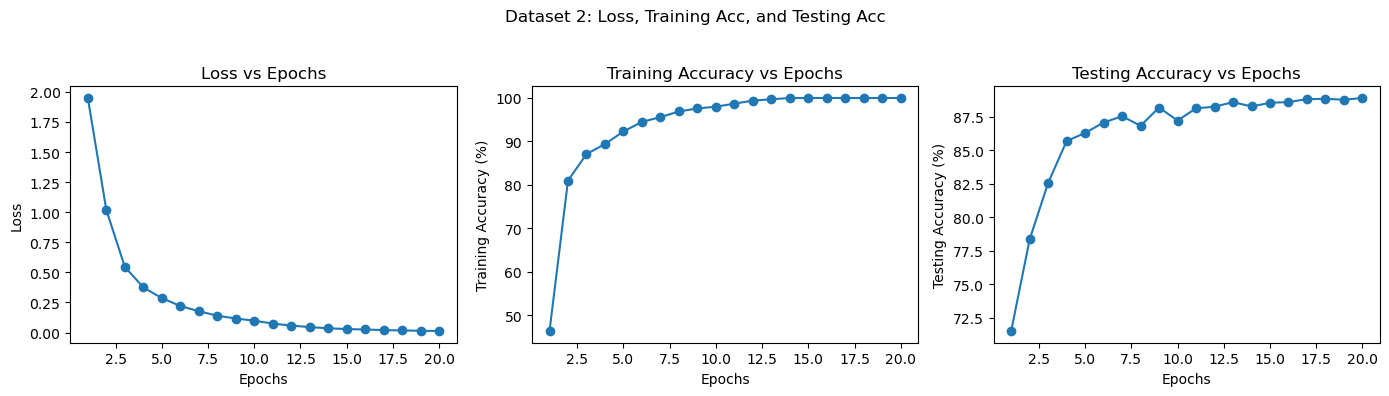

In [85]:
# ---------------------------
# Main Routine for Dataset 2
# ---------------------------
if __name__ == '__main__':
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Configuration: select which dataset to train (1,2,3, or 4)
    dataset_choice = 2  # CHANGE THIS value to 1, 2, 3, or 4
    
    # Hyperparameters (adjust as desired)
    batch_size = 128
    num_epochs = 20
    learning_rate = 0.001
    optimizer_choice = 'adam'  # or 'sgd'
    init_method = 'xavier'     # or 'he'
    hidden_units_list = [256, 128]  # example hidden layer sizes
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Select dataset and define input/output dimensions based on dataset
    if dataset_choice == 1:
        print("Using Dataset 1: 50,000 training images (original MNIST)")
        train_loader, test_loader = get_dataset1(batch_size)
        input_size = 28 * 28  # flattened image size
        num_classes = 10
    elif dataset_choice == 2:
        print("Using Dataset 2: 1,000 training images (original MNIST)")
        train_loader, test_loader = get_dataset2(batch_size)
        input_size = 28 * 28
        num_classes = 10
    elif dataset_choice == 3:
        print("Using Dataset 3: Full MNIST with modified brightness")
        train_loader, test_loader = get_dataset3(batch_size)
        input_size = 28 * 28
        num_classes = 10
    elif dataset_choice == 4:
        print("Using Dataset 4: Concatenated three-digit images")
        train_loader, test_loader = get_dataset4(batch_size)
        # Each new image is (1, 84, 28) after vertical stacking.
        input_size = 84 * 28
        num_classes = 1000  # labels range from 0 to 999
        # For more complex task consider adjusting network architecture.
        hidden_units_list = [512, 256, 128]  # example for higher capacity
    else:
        raise ValueError("dataset_choice must be 1, 2, 3, or 4")
    
    # Create model
    model = FullyConnectedNet(input_size, hidden_units_list, num_classes, init_method=init_method)
    total_params = count_parameters(model)
    print(f"Total number of parameters: {total_params}")

    # Define loss criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    if optimizer_choice.lower() == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    # Train the network
    print("Starting training...\n")
    train_loss, train_acc, test_acc = train_model(model, train_loader, test_loader,
                                                  criterion, optimizer, num_epochs, device)
    
    # Compute final accuracies and score ratio:
    final_train_acc = train_acc[-1]
    final_test_acc  = test_acc[-1]
    score_ratio = final_test_acc / (total_params ** (1/10))
    print(f"\nFinal Training Accuracy: {final_train_acc:.2f}%")
    print(f"Final Testing Accuracy: {final_test_acc:.2f}%")
    print(f"Score Ratio: {score_ratio:.4f}")
    
    # Plot training convergence curves
    plot_title = f"Dataset {dataset_choice}: Loss, Training Acc, and Testing Acc"
    plot_curves(train_loss, train_acc, test_acc, title=plot_title)

Next, let us consider the third set. 

Using Dataset 3: Full MNIST with modified brightness
Total number of parameters: 235146
Starting training...

Epoch 1/20 -- Loss: 1.4473 | Train Acc: 54.25% | Test Acc: 75.77%
Epoch 2/20 -- Loss: 0.6398 | Train Acc: 80.38% | Test Acc: 84.13%
Epoch 3/20 -- Loss: 0.5251 | Train Acc: 83.65% | Test Acc: 85.82%
Epoch 4/20 -- Loss: 0.4772 | Train Acc: 85.39% | Test Acc: 84.16%
Epoch 5/20 -- Loss: 0.4610 | Train Acc: 85.94% | Test Acc: 88.43%
Epoch 6/20 -- Loss: 0.4295 | Train Acc: 86.87% | Test Acc: 89.29%
Epoch 7/20 -- Loss: 0.4094 | Train Acc: 87.44% | Test Acc: 85.07%
Epoch 8/20 -- Loss: 0.3886 | Train Acc: 88.09% | Test Acc: 88.40%
Epoch 9/20 -- Loss: 0.3602 | Train Acc: 89.05% | Test Acc: 88.35%
Epoch 10/20 -- Loss: 0.3599 | Train Acc: 88.95% | Test Acc: 91.46%
Epoch 11/20 -- Loss: 0.3466 | Train Acc: 89.32% | Test Acc: 89.21%
Epoch 12/20 -- Loss: 0.3268 | Train Acc: 89.89% | Test Acc: 90.19%
Epoch 13/20 -- Loss: 0.3291 | Train Acc: 89.79% | Test Acc: 90.93%
Epoch 14/20 -- Loss: 0.3081 

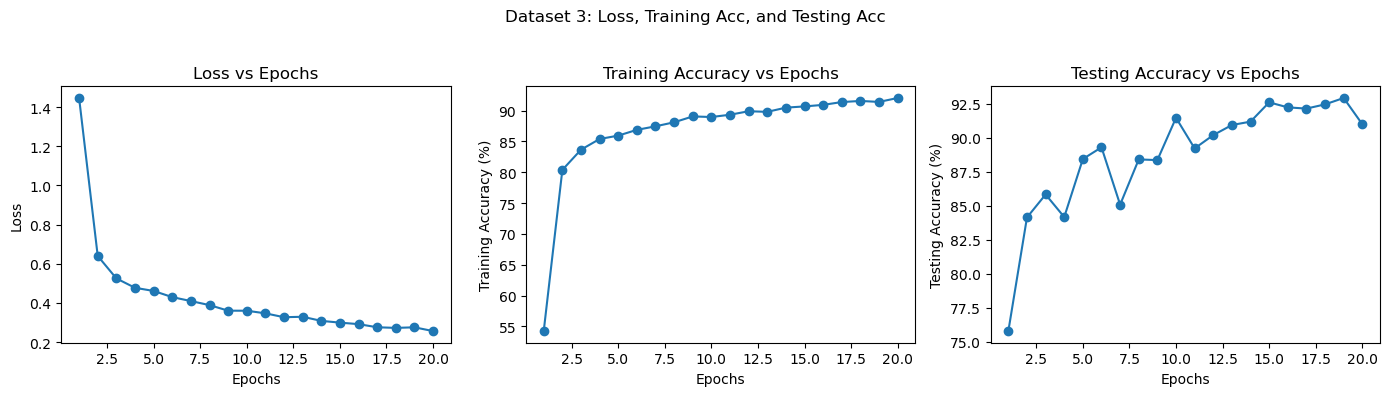

In [86]:
# ---------------------------
# Main Routine for Dataset 3
# ---------------------------
if __name__ == '__main__':
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Configuration: select which dataset to train (1,2,3, or 4)
    dataset_choice = 3  # CHANGE THIS value to 1, 2, 3, or 4
    
    # Hyperparameters (adjust as desired)
    batch_size = 128
    num_epochs = 20
    learning_rate = 0.001
    optimizer_choice = 'adam'  # or 'sgd'
    init_method = 'xavier'     # or 'he'
    hidden_units_list = [256, 128]  # example hidden layer sizes
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Select dataset and define input/output dimensions based on dataset
    if dataset_choice == 1:
        print("Using Dataset 1: 50,000 training images (original MNIST)")
        train_loader, test_loader = get_dataset1(batch_size)
        input_size = 28 * 28  # flattened image size
        num_classes = 10
    elif dataset_choice == 2:
        print("Using Dataset 2: 1,000 training images (original MNIST)")
        train_loader, test_loader = get_dataset2(batch_size)
        input_size = 28 * 28
        num_classes = 10
    elif dataset_choice == 3:
        print("Using Dataset 3: Full MNIST with modified brightness")
        train_loader, test_loader = get_dataset3(batch_size)
        input_size = 28 * 28
        num_classes = 10
    elif dataset_choice == 4:
        print("Using Dataset 4: Concatenated three-digit images")
        train_loader, test_loader = get_dataset4(batch_size)
        # Each new image is (1, 84, 28) after vertical stacking.
        input_size = 84 * 28
        num_classes = 1000  # labels range from 0 to 999
        # For more complex task consider adjusting network architecture.
        hidden_units_list = [512, 256, 128]  # example for higher capacity
    else:
        raise ValueError("dataset_choice must be 1, 2, 3, or 4")
    
    # Create model
    model = FullyConnectedNet(input_size, hidden_units_list, num_classes, init_method=init_method)
    total_params = count_parameters(model)
    print(f"Total number of parameters: {total_params}")

    # Define loss criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    if optimizer_choice.lower() == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    # Train the network
    print("Starting training...\n")
    train_loss, train_acc, test_acc = train_model(model, train_loader, test_loader,
                                                  criterion, optimizer, num_epochs, device)
    
    # Compute final accuracies and score ratio:
    final_train_acc = train_acc[-1]
    final_test_acc  = test_acc[-1]
    score_ratio = final_test_acc / (total_params ** (1/10))
    print(f"\nFinal Training Accuracy: {final_train_acc:.2f}%")
    print(f"Final Testing Accuracy: {final_test_acc:.2f}%")
    print(f"Score Ratio: {score_ratio:.4f}")
    
    # Plot training convergence curves
    plot_title = f"Dataset {dataset_choice}: Loss, Training Acc, and Testing Acc"
    plot_curves(train_loss, train_acc, test_acc, title=plot_title)

Finally, let us consider the fourth dataset.

Using Dataset 4: Concatenated three-digit images
Total number of parameters: 1497960
Starting training...

Epoch 1/20 -- Loss: 4.2986 | Train Acc: 16.89% | Test Acc: 38.90%
Epoch 2/20 -- Loss: 1.6292 | Train Acc: 53.68% | Test Acc: 59.30%
Epoch 3/20 -- Loss: 1.0063 | Train Acc: 70.35% | Test Acc: 67.65%
Epoch 4/20 -- Loss: 0.6974 | Train Acc: 78.90% | Test Acc: 70.99%
Epoch 5/20 -- Loss: 0.5046 | Train Acc: 84.48% | Test Acc: 75.30%
Epoch 6/20 -- Loss: 0.3739 | Train Acc: 88.14% | Test Acc: 75.62%
Epoch 7/20 -- Loss: 0.2915 | Train Acc: 90.49% | Test Acc: 76.91%
Epoch 8/20 -- Loss: 0.2221 | Train Acc: 92.80% | Test Acc: 76.89%
Epoch 9/20 -- Loss: 0.1748 | Train Acc: 94.28% | Test Acc: 77.94%
Epoch 10/20 -- Loss: 0.1504 | Train Acc: 95.06% | Test Acc: 77.35%
Epoch 11/20 -- Loss: 0.1383 | Train Acc: 95.42% | Test Acc: 77.74%
Epoch 12/20 -- Loss: 0.1292 | Train Acc: 95.73% | Test Acc: 76.70%
Epoch 13/20 -- Loss: 0.1173 | Train Acc: 96.20% | Test Acc: 77.66%
Epoch 14/20 -- Loss: 0.1077 | T

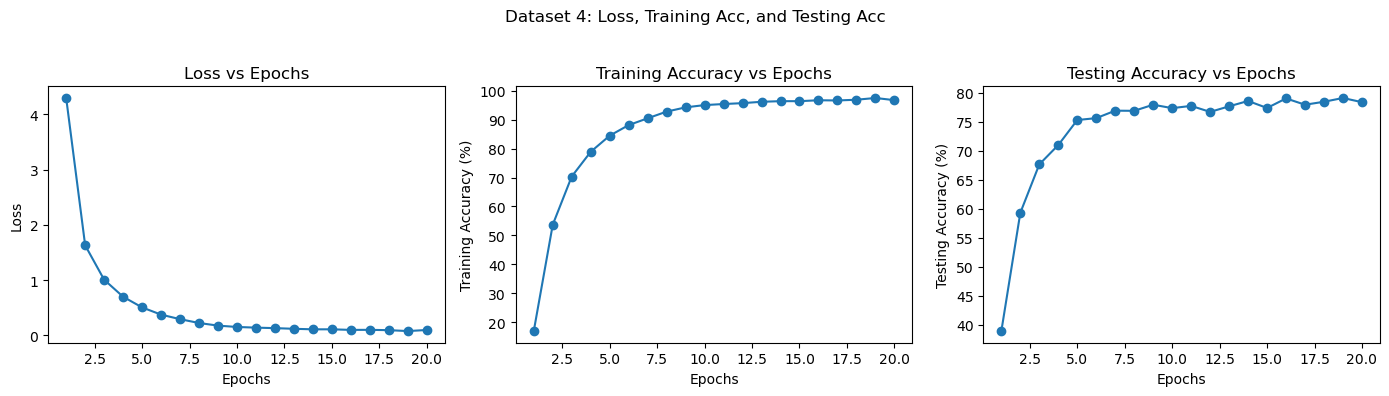

In [87]:
# ---------------------------
# Main Routine for Dataset 4
# ---------------------------
if __name__ == '__main__':
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Configuration: select which dataset to train (1,2,3, or 4)
    dataset_choice = 4  # CHANGE THIS value to 1, 2, 3, or 4
    
    # Hyperparameters (adjust as desired)
    batch_size = 128
    num_epochs = 20
    learning_rate = 0.001
    optimizer_choice = 'adam'  # or 'sgd'
    init_method = 'xavier'     # or 'he'
    hidden_units_list = [256, 128]  # example hidden layer sizes
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Select dataset and define input/output dimensions based on dataset
    if dataset_choice == 1:
        print("Using Dataset 1: 50,000 training images (original MNIST)")
        train_loader, test_loader = get_dataset1(batch_size)
        input_size = 28 * 28  # flattened image size
        num_classes = 10
    elif dataset_choice == 2:
        print("Using Dataset 2: 1,000 training images (original MNIST)")
        train_loader, test_loader = get_dataset2(batch_size)
        input_size = 28 * 28
        num_classes = 10
    elif dataset_choice == 3:
        print("Using Dataset 3: Full MNIST with modified brightness")
        train_loader, test_loader = get_dataset3(batch_size)
        input_size = 28 * 28
        num_classes = 10
    elif dataset_choice == 4:
        print("Using Dataset 4: Concatenated three-digit images")
        train_loader, test_loader = get_dataset4(batch_size)
        # Each new image is (1, 84, 28) after vertical stacking.
        input_size = 84 * 28
        num_classes = 1000  # labels range from 0 to 999
        # For more complex task consider adjusting network architecture.
        hidden_units_list = [512, 256, 128]  # example for higher capacity
    else:
        raise ValueError("dataset_choice must be 1, 2, 3, or 4")
    
    # Create model
    model = FullyConnectedNet(input_size, hidden_units_list, num_classes, init_method=init_method)
    total_params = count_parameters(model)
    print(f"Total number of parameters: {total_params}")

    # Define loss criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    if optimizer_choice.lower() == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    # Train the network
    print("Starting training...\n")
    train_loss, train_acc, test_acc = train_model(model, train_loader, test_loader,
                                                  criterion, optimizer, num_epochs, device)
    
    # Compute final accuracies and score ratio:
    final_train_acc = train_acc[-1]
    final_test_acc  = test_acc[-1]
    score_ratio = final_test_acc / (total_params ** (1/10))
    print(f"\nFinal Training Accuracy: {final_train_acc:.2f}%")
    print(f"Final Testing Accuracy: {final_test_acc:.2f}%")
    print(f"Score Ratio: {score_ratio:.4f}")
    
    # Plot training convergence curves
    plot_title = f"Dataset {dataset_choice}: Loss, Training Acc, and Testing Acc"
    plot_curves(train_loss, train_acc, test_acc, title=plot_title)